In [1]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.dates as md
import pickle as pkl
import xgboost
import shap
from tensorflow import keras
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler
from itertools import combinations, product
from src.colnames import topic_col, emotion_col, style_col, exclude_col
from utils import _pca_transform, plot_volume, plot_style_timeseries

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
df = pd.read_json('data/topic/data_renames.jsonl', 
                   orient='records',
                   lines=True)

### Overall number of Tweets

In [ ]:
style_short = [c for c in df.columns if 'rauh' in c or 'benoit' in c]

In [ ]:
summary = df.groupby('entity').aggregate({'created_at': 'min',
                                          'text': 'count'}).reset_index()
summary['end_date'] = '2022-06-29'
summary[['end_date',
         'created_at']] = summary[['end_date',
                                   'created_at']].apply(pd.to_datetime)
summary['n_days'] = (summary['end_date'] - summary['created_at']).dt.days
summary['tweets_per_day'] = (summary['text'] / summary['n_days']).round(2)
summary.columns = ['entity', 'first tweet', '# tweets', 'last tweet', '# days', 'tweets per day']
summary = summary[['entity', '# tweets', 'first tweet', 'last tweet', '# days', 'tweets per day']]

In [ ]:
summary

entity  # tweets first tweet last tweet  # days  tweets per day
0  10DowningStreet     11595  2008-03-26 2022-06-29    5208            2.23
1        EUCouncil      5652  2012-12-04 2022-06-29    3494            1.62
2    EU_Commission     29621  2010-06-23 2022-06-29    4389            6.75
3      Europarl_EN     18485  2009-04-30 2022-06-29    4808            3.84
4          IMFNews     19361  2009-03-24 2022-06-29    4845            4.00
5             OECD     13558  2009-03-19 2022-06-29    4850            2.80
6               UN     42664  2008-12-20 2022-06-29    4939            8.64
7              ecb     14948  2010-04-28 2022-06-29    4445            3.36
8          scotgov     12090  2009-06-16 2022-06-29    4761            2.54

### Plot tweet volume

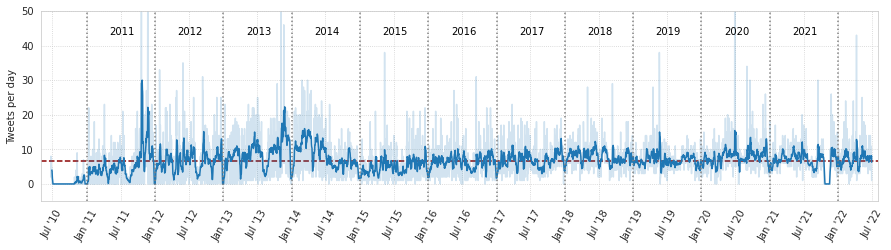

In [ ]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plot_volume(df, interactive=False,
            figsize=(15,3.5), 
            plot_smooth_only=False,
            exclude_entities=set(df.entity.unique().tolist()) - set(['EU_Commission']),
            ylim=True, freq='D', roll_window=7)

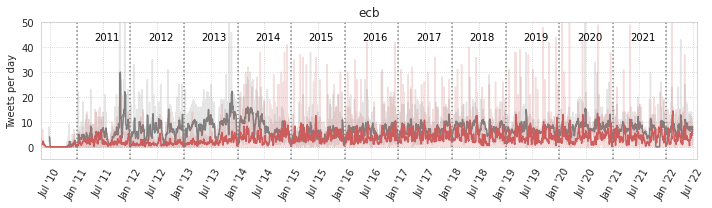

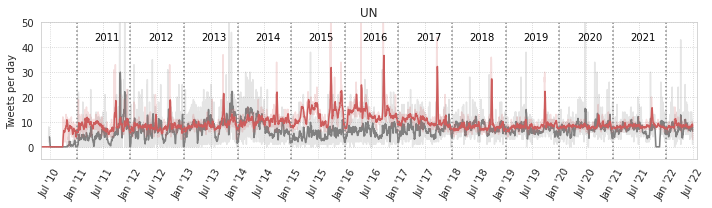

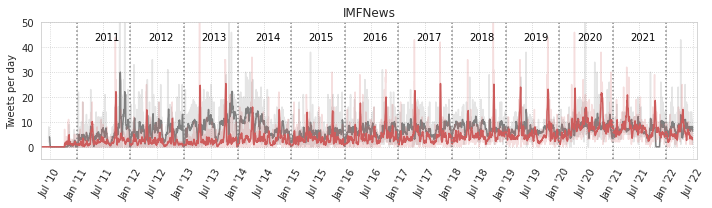

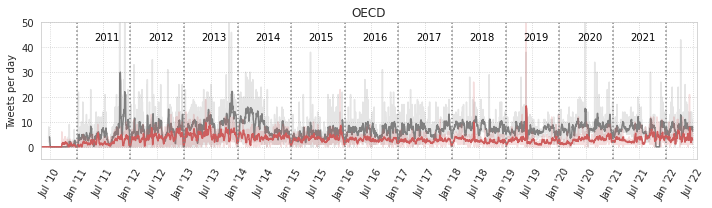

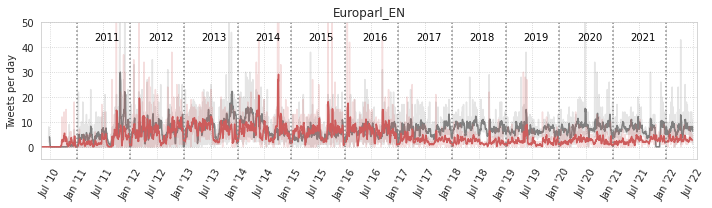

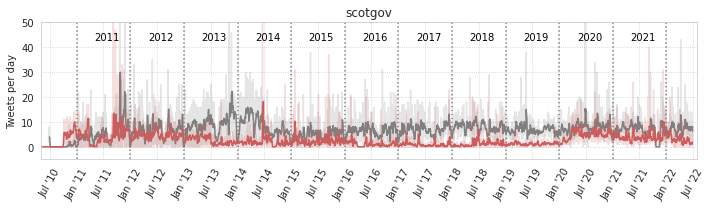

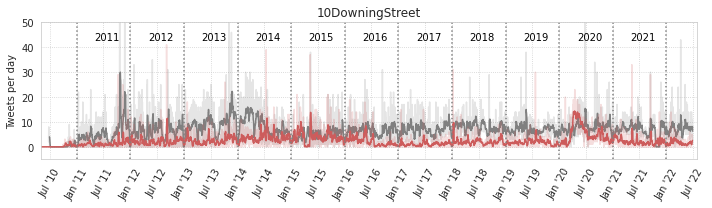

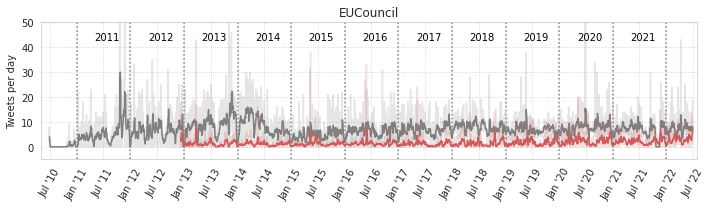

In [ ]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
for entity in set(df.entity.unique().tolist()) - set(['EU_Commission']):
    plot_volume(df, interactive=False,
                figsize=(10,3), 
                plot_smooth_only=False,
                exclude_entities=set(df.entity.unique().tolist()) - set(['EU_Commission', entity]),
                ylim=True, freq='D', roll_window=7,
                multiple=True, colors=['grey', 
                                       'indianred'], 
                savename=entity)

## Style

#### Qualitative style comparison

In [ ]:
df['n_mentions'] = df['text'].replace('[^@]','', regex=True).str.len()
df['n_hashtag'] = df['text'].replace('[^#]','', regex=True).str.len()
for c in ['n_hashtag', 'n_mentions', 'n_emojis']:
    df[c] = df[c] / df['benoit_sentence-length-words']

In [ ]:
df['year'] = df['created_at'].apply(lambda x: x.year)
df['month'] = df['created_at'].apply(lambda x: x.month)

In [ ]:
style_targets = [c for c in df.columns if any(['rauh' in c, 
                                               'benoit' in c, 
                                               'alpha_ratio' in c])] + \
                ['n_hashtag', 'n_mentions', 'is_link', 'n_emojis']
sentiment_targets = [c for c in df.columns if 'sentiment' in c]
categories = ['multimodal', 'word complexity', 'action', 'readability',
              'readability', 'overall length', 'sentence complexity',
              'sentence complexity', 'word complexity', 'word complexity',
              'action', 'multimodal', 'multimodal', 'multimodal', 'multimodal',
              'sentiment', 'sentiment', 'sentiment']
mapdict = dict(zip(style_targets+sentiment_targets, categories))

In [ ]:
new_names = ['% alphanumeric', 
             'frequency',
             'verb-to-noun ratio', 
             'Flesch-Kincaid Grade',
             'Flesch reading ease',
             '# words', 
             'sentence length (words)', 
             'sentence length (chars)', 
             'word length (syllables)',
             'word length (chars)', 
             '% nouns', 
             '% hashtag', '% mentions', 
             'has link', '% emojis',
             'negative sentiment', 'neutral sentiment', 'positive sentiment']

In [ ]:
param_categories = ['alpha', 'sentence complexity', 'action', 
                    'readability', 'sentence complexity', 
                    'sentence complexity', 'word complexity', 
                    'word complexity', 
                    'alpha', 'alpha', 'alpha', 'alpha', 
                    'sentiment', 'sentiment', 'sentiment', 
                    'word complexity', 'readability', 'action']
sort_entities = ['10DowningStreet', 'scotgov', 
                 'UN', 'Europarl_EN', 'EUCouncil', 
                 'ecb', 'IMFNews', 'OECD']

In [ ]:
df_standard = df.copy()
#for c in style_targets:
#    df_standard[c] = (df_standard[c] - df_standard[c].mean()) / df_standard[c].std()
df_standard = df_standard.rename(dict(zip(style_targets+sentiment_targets,
                                          new_names)), axis=1)

### Within EU Commission, over time

In [ ]:
df_reduced = df_standard.copy()
df_reduced = df_reduced.dropna(subset=new_names)
df_reduced = df_reduced.drop(['% nouns'], axis=1)

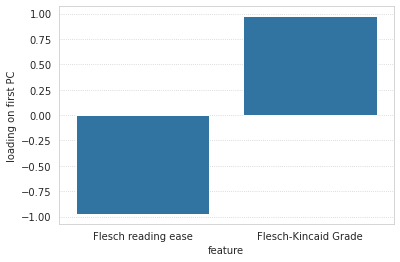

[0.94891961 0.05108039]


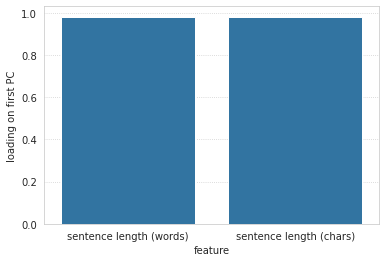

[0.96452659 0.03547341]


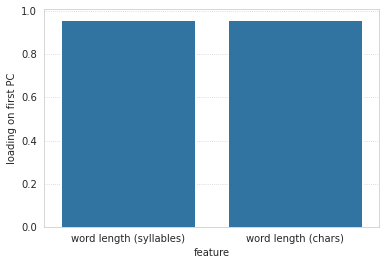

[0.92216651 0.07783349]


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
reduce_sets = [['Flesch reading ease',
                'Flesch-Kincaid Grade'],
               ['sentence length (words)',
                'sentence length (chars)'],
               ['word length (syllables)',
                'word length (chars)']]
new_names = ['reading complexity', 'sentence length', 'word length']

for rs, nn in zip(reduce_sets, new_names):
    X = df_reduced[rs].dropna()
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=len(rs))
    pca.fit(X)
    df_reduced[nn] = pca.transform(X)[:,0]
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loading_matrix = pd.DataFrame(loadings, columns=[f'PC{i}' 
                                                     for i in range(len(rs))], index=rs)
    loading_matrix = loading_matrix.reset_index().melt(id_vars='index')
    sns.barplot(data=loading_matrix[loading_matrix['variable']=='PC0'], 
                x='index', y='value', color=sns.color_palette()[0])
    plt.xlabel('feature')
    plt.ylabel('loading on first PC')
    plt.show()
    print(pca.explained_variance_ratio_)

In [ ]:
new_cols = ['reading complexity',
             'verb-to-noun ratio',
             '# words', # standalone
             'sentence length',
             'word length',
             'frequency',
             'negative sentiment', 'neutral sentiment', 'positive sentiment',
             '% alphanumeric', 
             '% hashtag', '% mentions', 
             'has link', '% emojis']

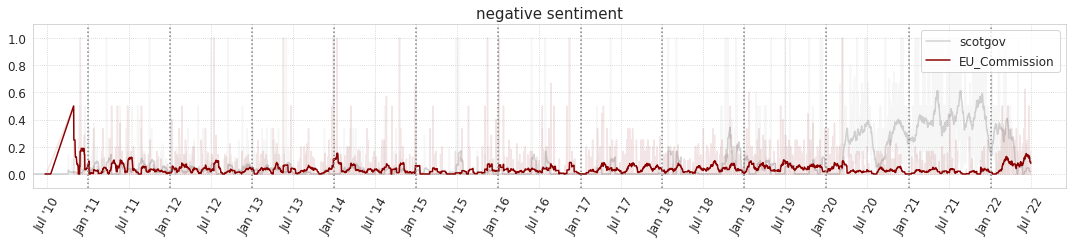

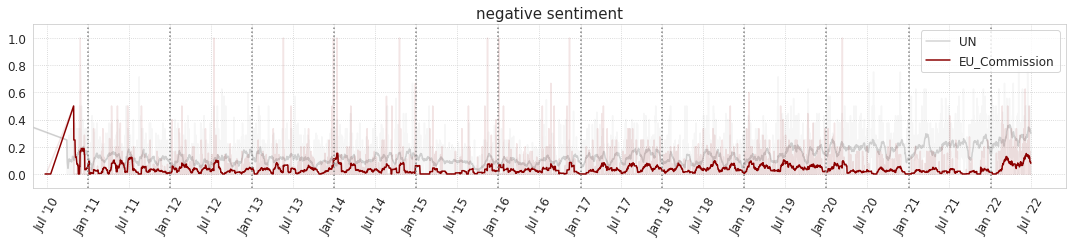

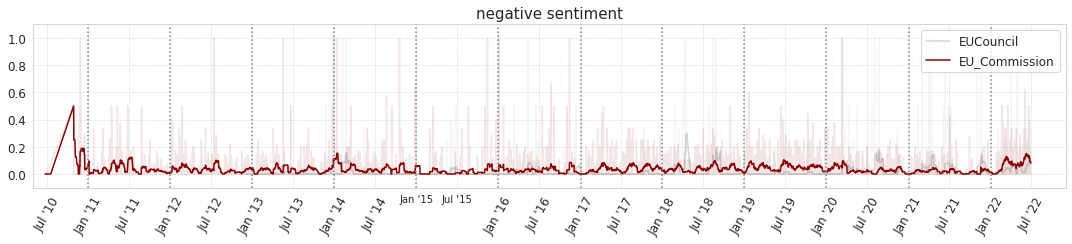

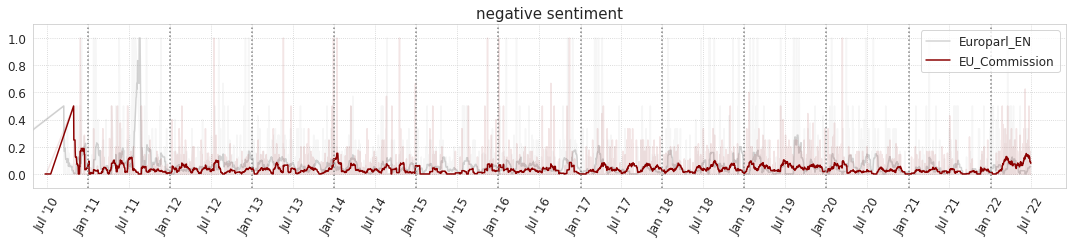

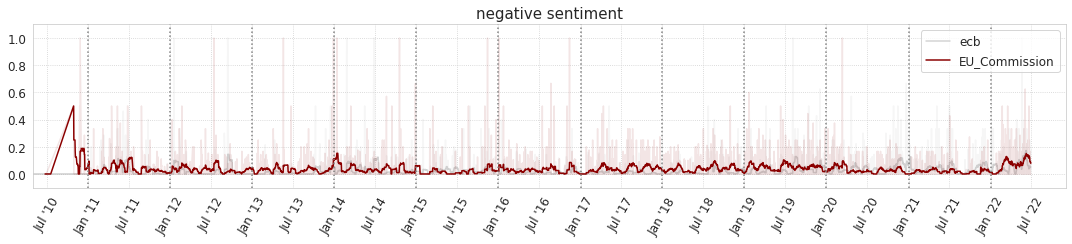

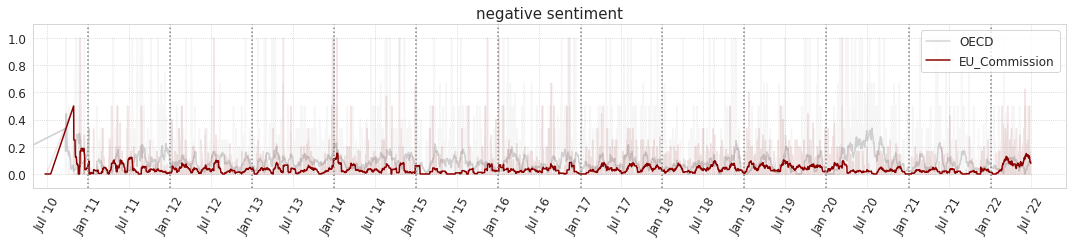

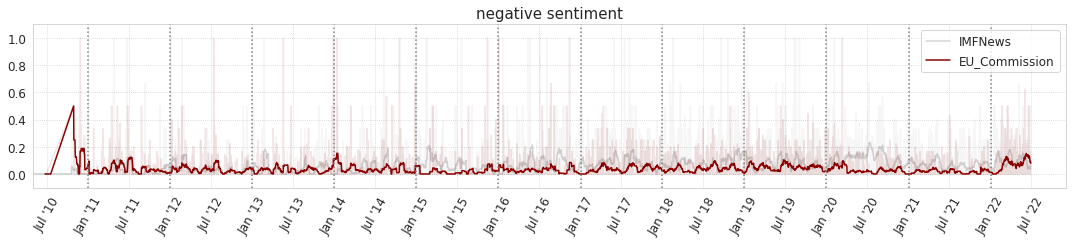

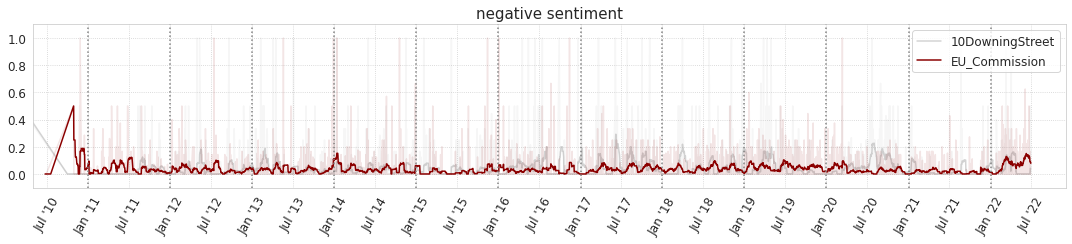

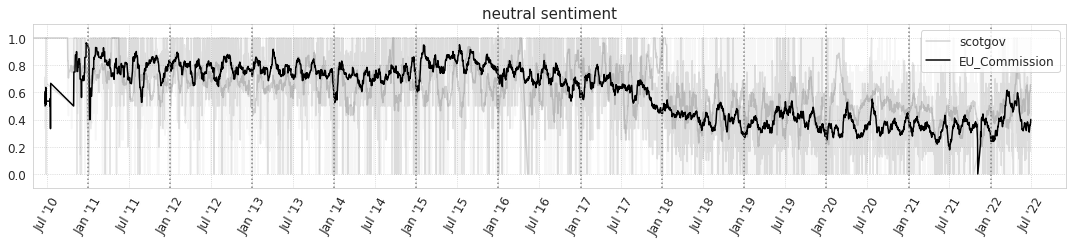

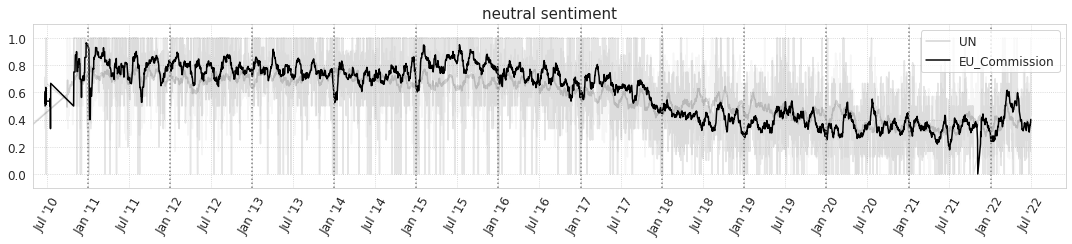

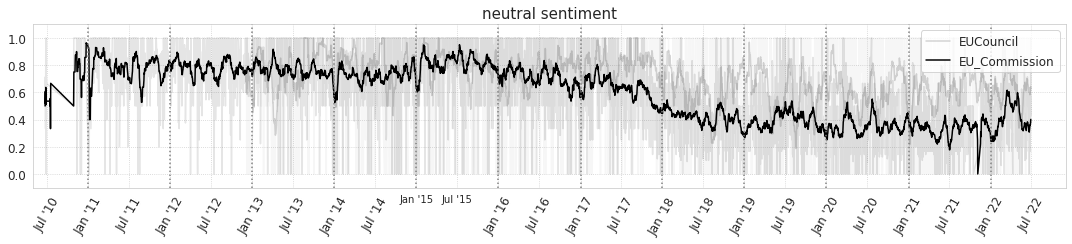

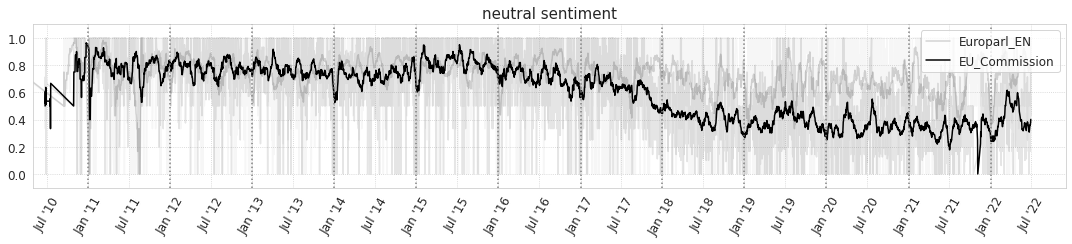

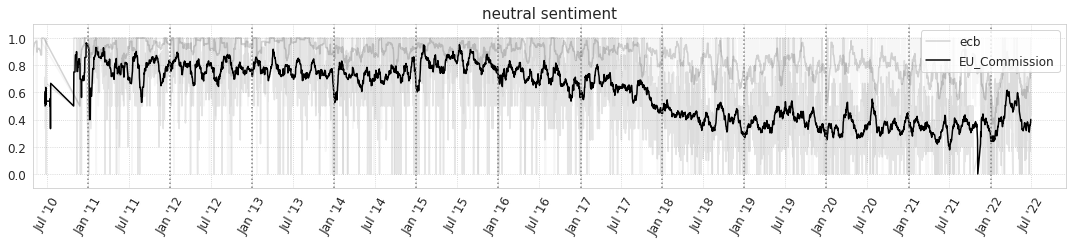

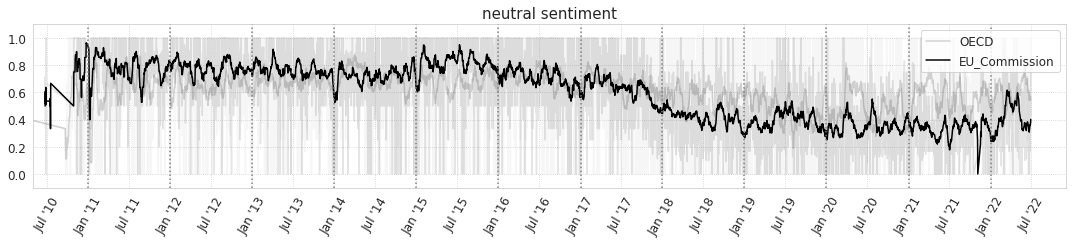

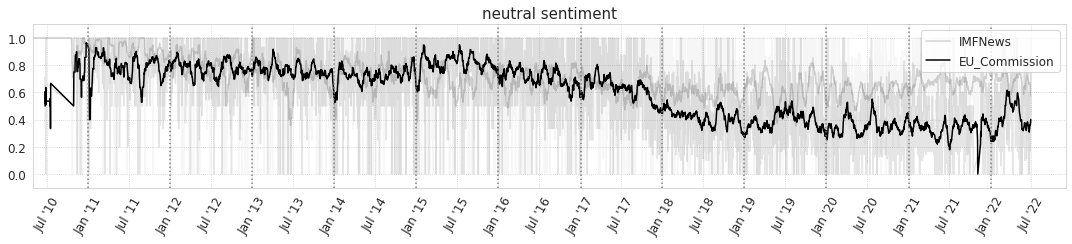

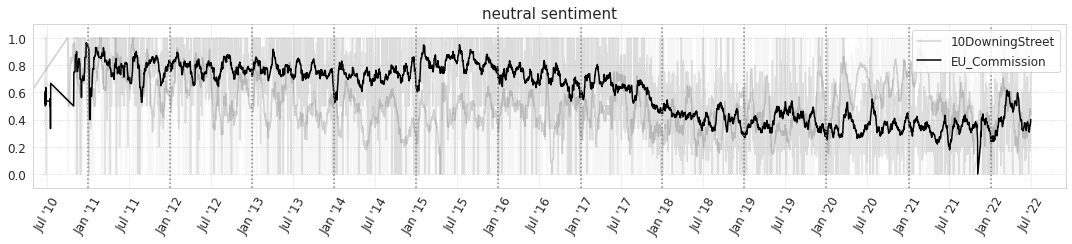

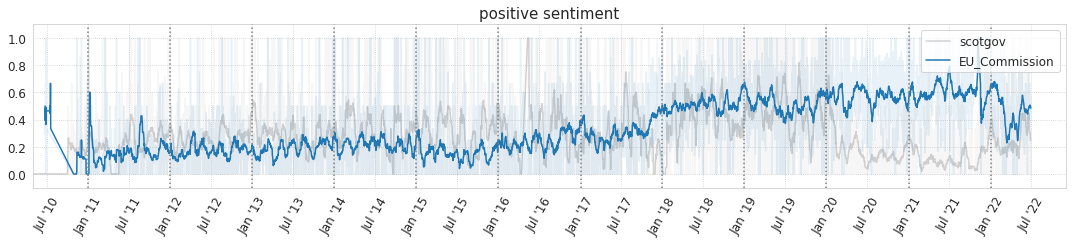

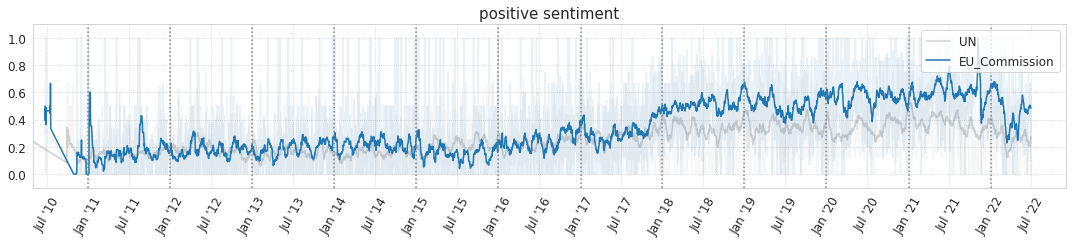

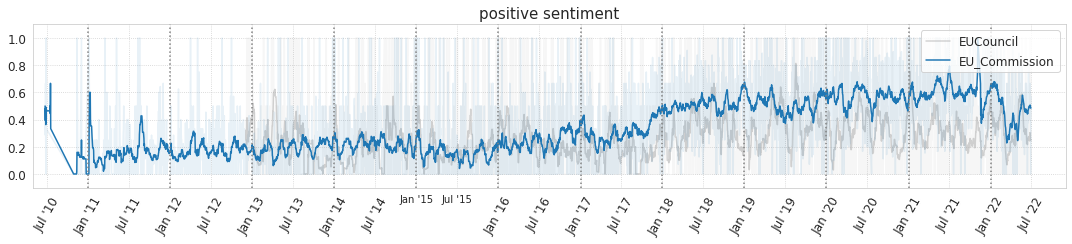

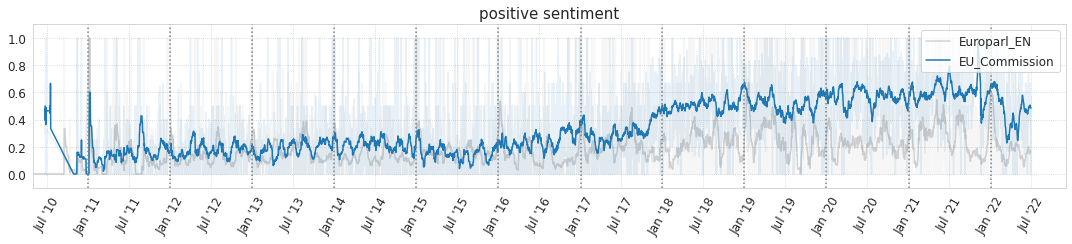

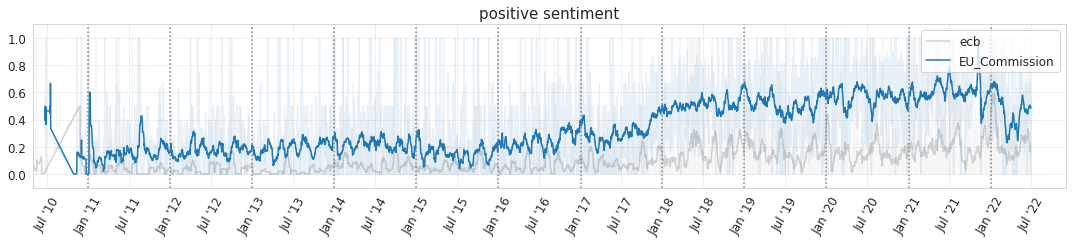

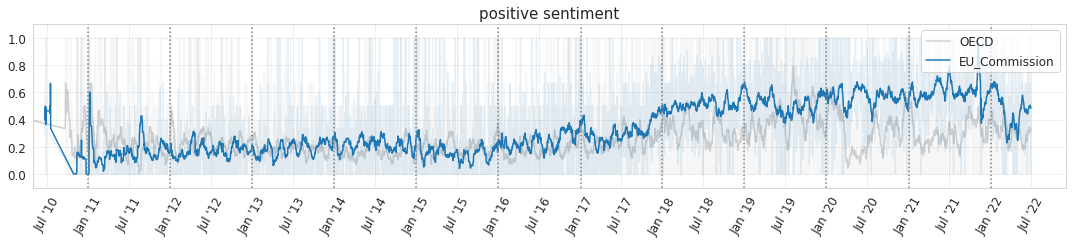

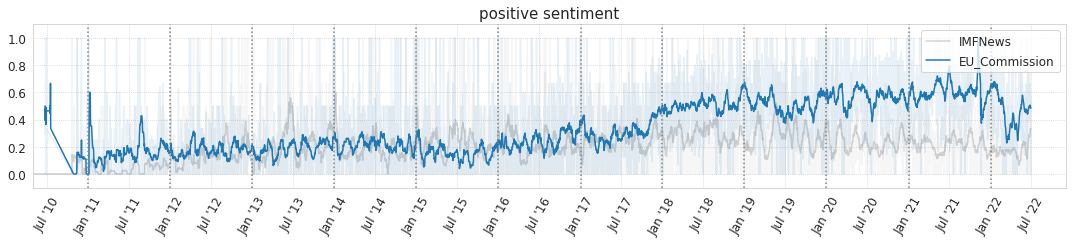

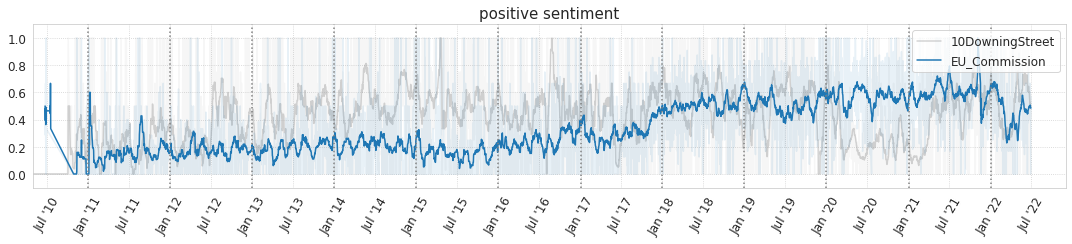

In [36]:
for c in [n for n in new_cols if 'sentiment' in n]:
    for e in df_reduced.entity.unique():
        if e != 'EU_Commission':
            if 'positive' in c:
                color = sns.color_palette()[0]
            elif 'neutral' in c:
                color = 'black'
            else:
                color = 'darkred'
            plot_style_timeseries(df_reduced, 
                                  entities=[e,'EU_Commission'],
                                  colors=['darkgrey', color],
                                  metric=c,
                                  freq='D', 
                                  roll_window=21,
                                  normalized=False,
                                  savename=f'sentiment_timeseries/{c}_{e}',
                                  plot_smooth_only=False,
                                  interactive=False,
                                  title=f'{c} - {e}',
                                  no_horizontal=True,
                                  ylim=(-0.1,1.1),
                                  figsize=(15,3.5))

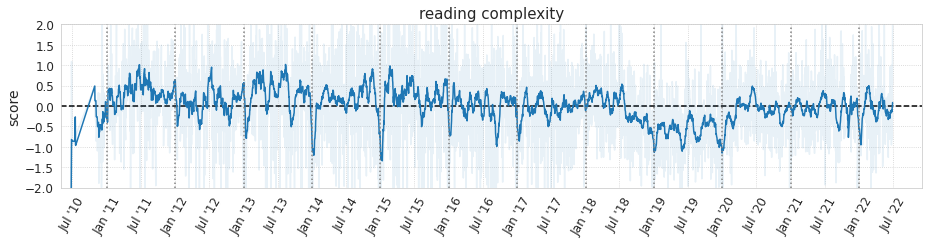

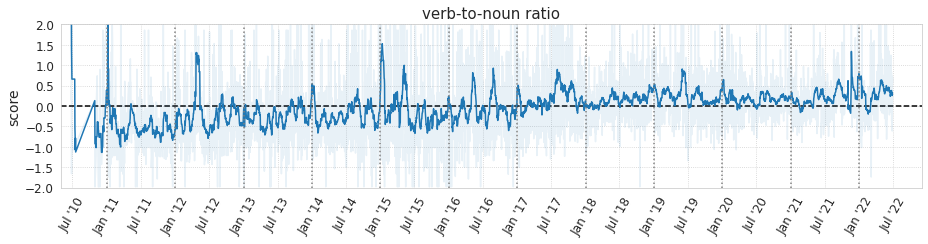

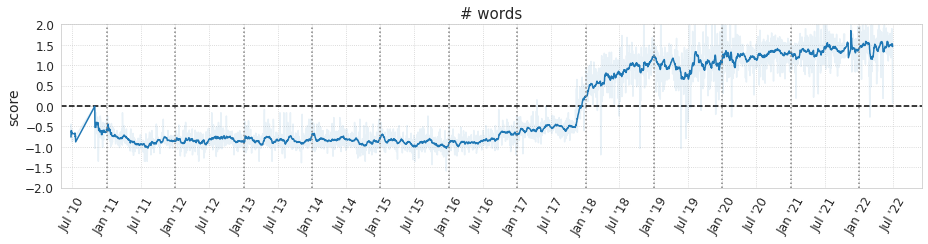

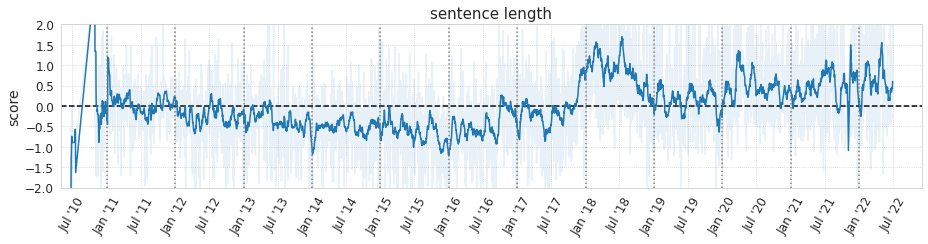

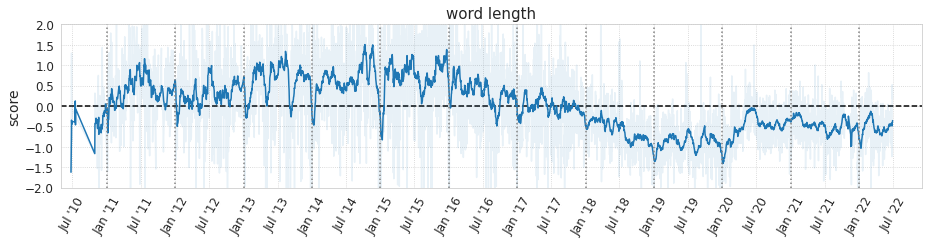

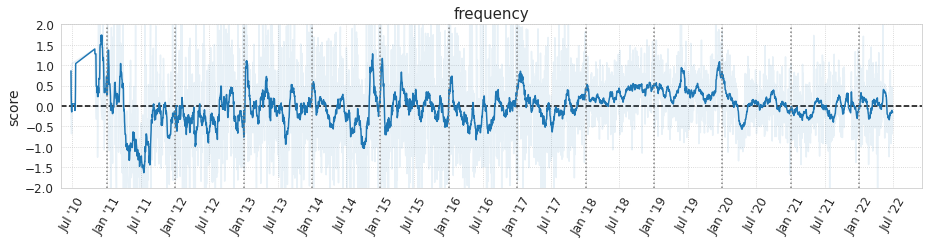

In [37]:
sub_cols = ['reading complexity',
             'verb-to-noun ratio',
             '# words',
             'sentence length',
             'word length',
             'frequency']
for i, c in enumerate(sub_cols):
    plot_style_timeseries(df_reduced, 
                          entities=['EU_Commission'],
                          metric=c,
                          freq='D', 
                          roll_window=21,
                          normalized=True,
                          savename=f'style_timeseries/{c}_{e}',
                          plot_smooth_only=False,
                          interactive=False,
                          no_horizontal='mean',
                          ylim=(-2,2),
                          figsize=(13,3.5), 
                          legend=False)

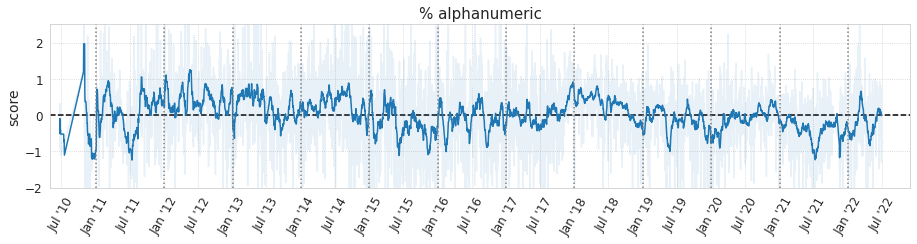

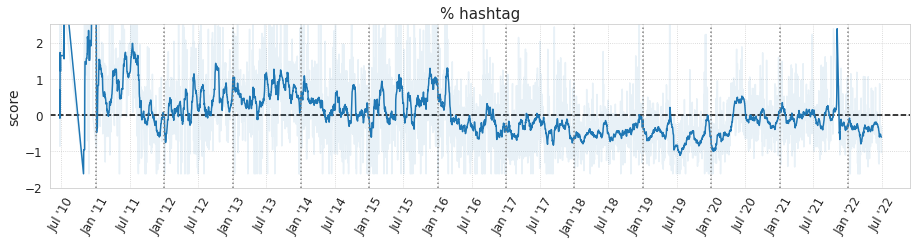

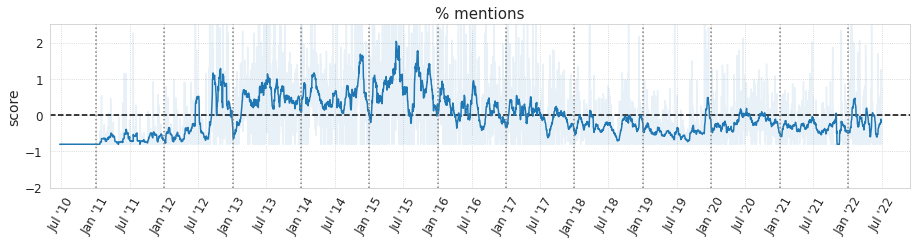

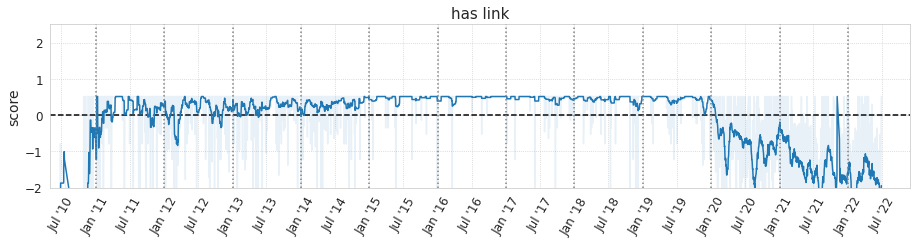

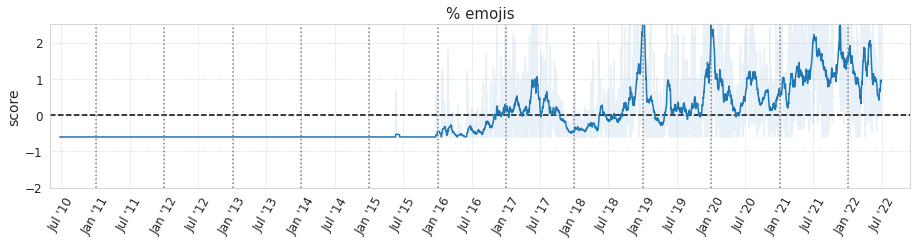

In [38]:
for i, c in enumerate(new_cols[9:]):
    plot_style_timeseries(df_reduced, 
                          entities=['EU_Commission'],
                          metric=c,
                          freq='D', 
                          roll_window=21,
                          normalized=True,
                          savename=f'style_timeseries/{c}_{e}',
                          plot_smooth_only=False,
                          interactive=False,
                          no_horizontal='mean',
                          ylim=(-2,2.5),
                          figsize=(13,3.5), 
                          legend=False)

#### Qualitative plot: overall similarity, per trait

In [ ]:
bow_targets = [c for c in df_standard.columns if 'bow_500' in c]

alpha_targets = ['is_link',
                 'n_hashtag',
                 'n_mentions',
                 'n_emojis']

action_targets = ['rauh_verb-to-noun', 
                  'benoit_prop-noun']

sentence_targets = ['benoit_overall-length', 
                    'benoit_sentence-length-words',
                    'benoit_sentence-length-characters']

word_targets = ['rauh_frequency',
                'benoit_word-length-syllables',
                'benoit_word-length-characters']

readability_targets = ['rauh_readability', 'benoit_readability']

feature_set_names = ['style (all)' ]

feature_sets = [style_targets]

In [ ]:
perfs = []
for r in range(5):
    print(f'Run {r}')
    
    for i in df_standard.year.unique():
        print(f'Year {i}')

        for feature, name in zip(feature_sets, feature_set_names):
            for e in set(df_standard.entity.unique()) - set(['EU_Commission']):

                scaler = StandardScaler()

                # Make datasets
                trains = []; vals = [];

                try:
                    for en in [e, 'EU_Commission']:
                            trains.append(df_standard[(df_standard['year']==i) & 
                                                    (df_standard['entity']==en)].sample(1000, replace=True))
                            vals.append(df_standard[(df_standard['year']==i) & 
                                                  (df_standard['entity']==en)].sample(1000, replace=True))

                    trains = pd.concat(trains).sample(frac=1)
                    train_X = scaler.fit_transform(trains[feature].fillna(0).values)
                    train_y = trains['entity'].map({e: 1.0, 'EU_Commission': 0.0})
                    vals = pd.concat(vals).sample(frac=1)
                    val_X = scaler.fit_transform(vals[feature].fillna(0).values)
                    val_y = vals['entity'].map({e: 1.0, 'EU_Commission': 0.0})

                    # Define model
                    inputs = keras.Input(shape=(len(feature)))
                    x = keras.layers.Dense(units=len(feature))(inputs)
                    x = keras.layers.Dense(units=len(feature))(x)
                    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
                    model = keras.Model(inputs, outputs)
                    model.compile(optimizer='rmsprop', 
                                  loss=keras.losses.BinaryCrossentropy(from_logits=False),
                                  metrics='accuracy')

                    # Fit and evaluate
                    model.fit(train_X, train_y, epochs=100, 
                              verbose=0,
                              validation_split=.2, 
                              callbacks=keras.callbacks.EarlyStopping(patience=3))

                    # Plot
                    perfs.append((name, e, 
                                  round(model.evaluate(val_X, val_y, verbose=0)[1],3), 
                                  i, r))

                except:
                    continue
                    
perf_df = pd.DataFrame(perfs, columns=['name', 'entity', 'score', 'year', 'run'])

In [ ]:
perf_all = perf_df.copy()
perf_all.to_json('logs/classifiers_time.jsonl', orient='records', lines=True)

In [ ]:
perf_df = perf_df.groupby(['name', 'entity', 'year']).score.mean().reset_index()
perf_wide = pd.pivot(perf_df[perf_df['year']>=2012], index=['name','entity'], 
                     columns='year', values='score').reset_index()

In [ ]:
for c in perf_df['name'].unique():
    target_data = perf_wide[(perf_wide['name']==c) ]
    target_data = target_data.sort_values(by='entity')
    entities = target_data.entity.tolist()
    target_data = target_data.drop(['name', 'entity'], axis=1)
    plt.subplots(figsize=(6,2))
    sns.heatmap(target_data, cmap='RdGy_r', robust=True, square=False)
    plt.xticks(ticks=range(grouped.year.nunique()-2),
               labels=sorted(set(grouped.year.unique()) - set([2010,2011])),
               rotation=45, ha='center')
    plt.yticks(ticks=np.arange(0.5,8.5,1), labels=entities, rotation=0)
    plt.title('Style-based discriminability')
    plt.xlabel('')
    plt.show()

### Qualitative comparison

In [39]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

ests = []
for t in new_cols[:6]: # :6 or 9:
    print(t)
    scaler = StandardScaler()
    new_t_name = t.replace('-','_')
    new_t_name = new_t_name.replace(' ','_')
    new_t_name = new_t_name.replace('#','n')
    new_t_name = new_t_name.replace('%','prop')
    data = df_reduced[df_reduced['year']>=2021].rename({t: new_t_name}, axis=1).fillna(0)
    data[new_t_name] = scaler.fit_transform(data[[new_t_name]])
    formula = f"{new_t_name} ~ C(entity, Treatment(reference='EU_Commission'))" # + {' + '.join(topic_col)} # added topics for control
    
    # Specify model
    mod = smf.rlm(formula, data=data, M=sm.robust.norms.HuberT())
    
    # Freq workflow
    res = mod.fit()
    
    # Save estimates
    est_df = pd.DataFrame(res.params, columns=['param'])
    est_df['predictor'] = est_df.index.str.replace(r"C\(entity, Treatment\(reference='EU_Commission'\)\)\[T\.", "", 
                                                   regex=True)
    est_df['predictor'] = est_df['predictor'].str.replace(r"\]", "", regex=True)
    est_df['target'] = t
    est_df['p_val'] = res.pvalues.values
    est_df = est_df[~est_df['predictor'].isin(topic_col)]
    est_df = est_df.reset_index(drop=True)
    est_df = est_df[est_df['predictor']!='Intercept']
    ests.append(est_df)
    
# Make joint dataset
ests = pd.concat(ests)
ests['param'] = ests['param'] * (ests['p_val']<0.05).astype(int)
ests.drop('p_val', axis=1, inplace=True)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


reading complexity
verb-to-noun ratio
# words
sentence length
word length
frequency


reading complexity


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


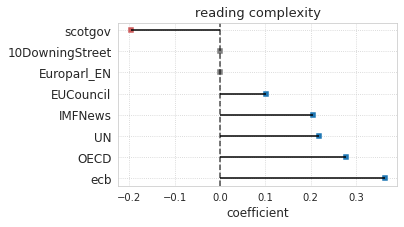

verb-to-noun ratio


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


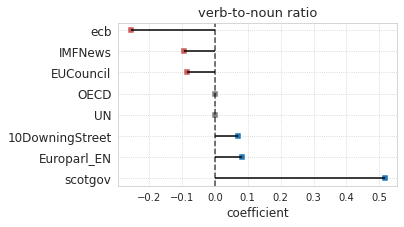

# words


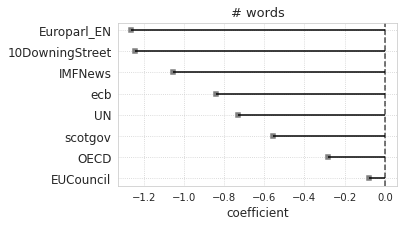

sentence length


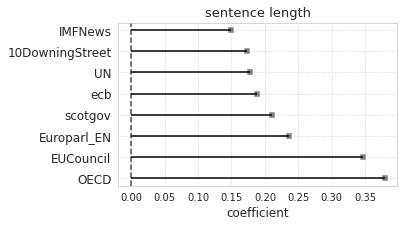

word length


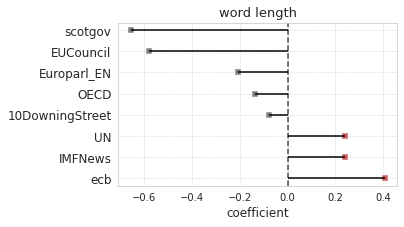

frequency


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


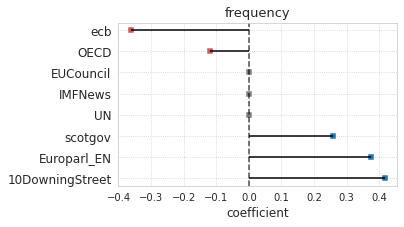

In [40]:
import matplotlib.ticker as ticker
sns.set_style('whitegrid', {'axes.grid' : True, 'grid.linestyle': 'dotted'})
for t in ests.target.unique():
    print(t)
    dta = ests[ests['target']==t].sort_values(by='param')
    dta['sign'] = (dta['param'] > 0).astype(int)
    dta['sign'] = np.where(dta['param']==0, -1, dta['sign'])
    plt.subplots(figsize=(5,3))
    plt.axvline(0, linestyle='--', color='black', alpha=.7)
    for i in range(8):
        if dta.iloc[i,:]['param'] <= 0:
            xmin = dta.iloc[i,:]['param']
            xmax = 0
        else:
            xmax = dta.iloc[i,:]['param']
            xmin = 0
        plt.hlines(y=[i], xmin=xmin, xmax=xmax, color='black')
    palette = [sns.color_palette()[0], 'indianred', 'grey'][::-1]
    n = dta.sign.nunique()
    palette = palette[:n]
    ax = sns.scatterplot(data=dta, y='predictor', x='param', hue='sign', marker='s',
                         palette=palette)
    plt.legend().remove()
    plt.title(t, fontsize=13)
    plt.xlabel('coefficient', fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('')
    plt.show()

In [42]:
df_reduced['date'] = pd.to_datetime(df_reduced[['year', 'month']].assign(day=1)).dt.strftime('%b \'%y')
vals = pd.to_datetime(df_reduced[['year', 'month']].assign(day=1)).sort_values().dt.strftime('%b \'%y').unique()
dct = dict(zip(vals, range(vals.shape[0])))
df_reduced['date_mapped'] = df_reduced['date'].replace(dct)

In [431]:
df_reduced.to_json('data/topic/data_renamed_reduced.jsonl', orient='records', lines=True)


### Results of predictive models

In [43]:
# d = json.load(open('logs/transformers/sum_count.json'))
d = json.load(open('logs/engagement/sum_count.json'))

In [44]:
tr_res = pd.DataFrame(d).sort_values(by='test_r2')
tr_res['model'] = tr_res['model'].str.replace('sum_count_', '')

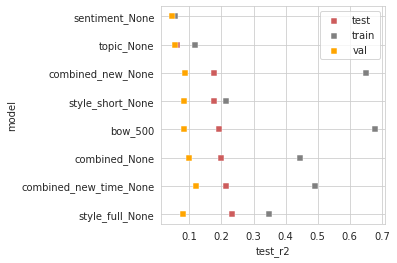

In [45]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data=tr_res, x='test_r2', y='model', label='test', color='indianred', marker='s')
sns.scatterplot(data=tr_res, x='train_r2', y='model', label='train', color='grey', marker='s')
sns.scatterplot(data=tr_res, x='val_r2', y='model', label='val', color='orange', marker='s')
plt.show()

In [46]:
dfs = []
for metric in ['sum']:
    fs = glob.glob(f'logs/*/{metric}_count/pred*.pkl')
    for f in fs:
        print(f)
        f_df = pd.read_pickle(f)
        f_df['metric'] = metric
        dfs.append(f_df)
    metrics = pd.concat(dfs, ignore_index=True)
    

logs/engagement/sum_count/pred_sum_count_topic_None_train.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_train.pkl
logs/engagement/sum_count/pred_sum_count_sentiment_None_test.pkl
logs/engagement/sum_count/pred_sum_count_topic_None_val.pkl
logs/engagement/sum_count/pred_sum_count_bow_500_test.pkl
logs/engagement/sum_count/pred_sum_count_sentiment_None_val.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_val.pkl
logs/engagement/sum_count/pred_sum_count_combined_None_test.pkl
logs/engagement/sum_count/pred_sum_count_combined_None_train.pkl
logs/engagement/sum_count/pred_sum_count_combined_new_None_train.pkl
logs/engagement/sum_count/pred_sum_count_combined_new_time_None_test.pkl
logs/engagement/sum_count/pred_sum_count_bow_500_train.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_test.pkl
logs/engagement/sum_count/pred_sum_count_combined_new_time_None_val.pkl
logs/engagement/sum_count/pred_sum_count_combined_new_None_test.pkl
logs/engagement/sum_

In [47]:
spears = metrics.groupby(['metric', 'split',
                          'model_name'])[['label', 
                                          'prediction']].apply(lambda x: x.corr('spearman').iloc[0,1]).reset_index()
spears = spears.rename({0: 'spearman_cor'}, axis=1)

In [48]:
spears

metric  split                                         model_name  \
0     sum   test                                  sum_count_bow_500   
1     sum   test                            sum_count_combined_None   
2     sum   test                        sum_count_combined_new_None   
3     sum   test                   sum_count_combined_new_time_None   
4     sum   test  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
5     sum   test  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
6     sum   test  sum_count_distilbert-base-uncased_lr-1e-05_wde...   
7     sum   test  sum_count_distilbert-base-uncased_lr-1e-05_wde...   
8     sum   test                           sum_count_sentiment_None   
9     sum   test                          sum_count_style_full_None   
10    sum   test                         sum_count_style_short_None   
11    sum   test                               sum_count_topic_None   
12    sum  train                                  sum_count_bow_500   
13    sum  train                            sum_count_combined_None   
14    sum  train                        sum_count_combined_new_None   
15    sum  train                   sum_count_combined_new_time_None   
16    sum  train  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
17    sum  train  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
18    sum  train  sum_count_distilbert-base-uncased_lr-1e-05_wde...   
19    sum  train  sum_count_distilbert-base-uncased_lr-1e-05_wde...   
20    sum  train                           sum_count_sentiment_None   
21    sum  train                          sum_count_style_full_None   
22    sum  train                         sum_count_style_short_None   
23    sum  train                               sum_count_topic_None   
24    sum    val                                  sum_count_bow_500   
25    sum    val                            sum_count_combined_None   
26    sum    val                        sum_count_combined_new_None   
27    sum    val                   sum_count_combined_new_time_None   
28    sum    val  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
29    sum    val  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
30    sum    val  sum_count_distilbert-base-uncased_lr-1e-05_wde...   
31    sum    val  sum_count_distilbert-base-uncased_lr-1e-05_wde...   
32    sum    val                           sum_count_sentiment_None   
33    sum    val                          sum_count_style_full_None   
34    sum    val                         sum_count_style_short_None   
35    sum    val                               sum_count_topic_None   

    spearman_cor  
0       0.695578  
1       0.746385  
2       0.719267  
3       0.847564  
4       0.752813  
5       0.032487  
6       0.306303  
7       0.839238  
8       0.509414  
9       0.729663  
10      0.685771  
11      0.564465  
12      0.776795  
13      0.751553  
14      0.730607  
15      0.856587  
16      0.757291  
17      0.046191  
18      0.304803  
19      0.908941  
20      0.496221  
21      0.737605  
22      0.698524  
23      0.578028  
24      0.681547  
25      0.729139  
26      0.710158  
27      0.832959  
28      0.753655  
29      0.035013  
30      0.320070  
31      0.846386  
32      0.488881  
33      0.709596  
34      0.670264  
35      0.568801

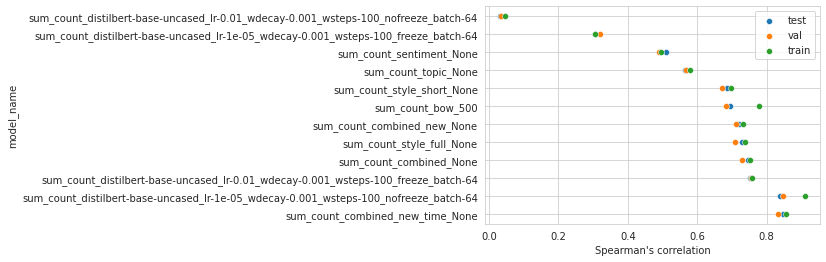

In [49]:
for metric in ['sum']:
    for out_metric in ['spearman_cor']:
        spears = spears.sort_values(by=out_metric, ascending=True)
        for split in ['test',  'val', 'train']:
            sns.scatterplot(data=spears[(spears['split']==split) & \
                                        (spears['metric']==metric)],
                            y='model_name', x='spearman_cor', label=split)
        plt.xlabel('Spearman\'s correlation')
        plt.show()

### Predictive models

***** sum *****
logs/engagement/sum_count/sum_count_combined_new_time_None.pkl


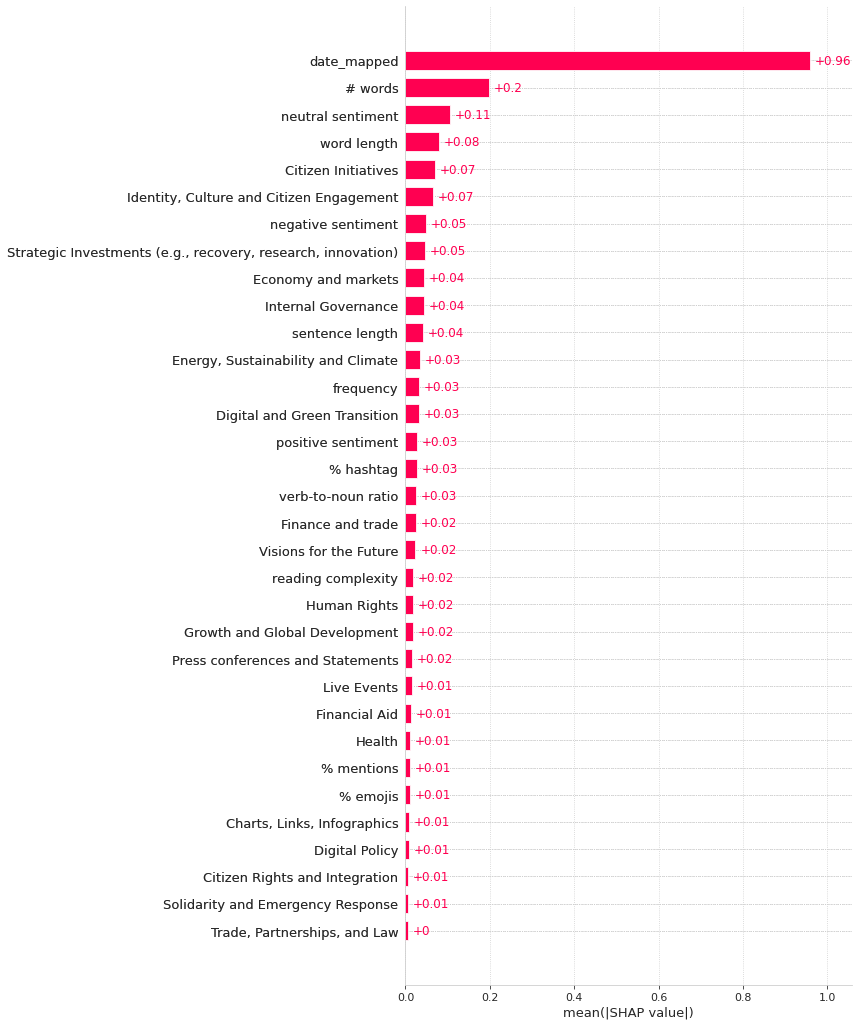

In [161]:
with xgboost.config_context(verbosity=0):
    for metric in ['sum']:
        print(f'***** {metric} *****')
        fnames = glob.glob(f'logs/engagement/{metric}_count/{metric}_count_*.pkl')
        for m in [f for f in fnames if 'combined_new' in f and 'time' in f]: # combined
            name = m.split('/')[-1]
            model = pkl.load(open(m, 'rb'))
            print(m)
            feature_names = new_topic_col + new_style_col + ['date_mapped']
            #if 'topic' in m:
            #    feature_names = topic_col
            #elif 'style_short' in m:
            #    feature_names = style_short
            #elif 'style_full' in m:
            #    feature_names = style_targets
            #elif 'combined' in m:
            #    feature_names = topic_col + emotion_col + style_targets 
            #elif 'sentiment' in m:
            #    feature_names = emotion_col
            #else:
            #    bow_nr = m.split('_')[-1].split('.')[0]
            #    tokenizer = pkl.load(open(f'logs/engagement/{metric}_count/tokenizer_bow-{bow_nr}.pkl',
            #                              'rb'))
            #    feature_names = tokenizer.get_feature_names()
                
            df = pd.DataFrame(zip(model.feature_importances_,
                                  feature_names), 
                              columns=['importance', 'feature'])
            df = df.sort_values(by='importance')
            #plt.subplots(figsize=(20,5))
            #sns.barplot(data=df, x='feature', y='importance', color='darkgrey')
            #plt.xticks(rotation=90)
            #plt.show()
            
            shaps = pkl.load(open(f'logs/engagement/{metric}_count/shap_{name}','rb'))
            if not 'topic' in m:
                df = df.tail(n=50)
                fig, ax = plt.subplots(figsize=(20,4))  
            shaps.feature_names = feature_names
            shap.plots.bar(shaps, max_display=50)
            #shap.summary_plot(shaps, plot_type='violin',
            #                  plot_size=(10,4))

    

In [51]:
from src.colnames import new_topic_col, new_style_col

33

In [117]:
shaps_df = pd.DataFrame(shaps.values.T)
shaps_df['feature_name'] = feature_names
shaps_long = shaps_df.melt(id_vars='feature_name')
norm_data = StandardScaler().fit_transform(shaps.data)
shaps_df_data = pd.DataFrame(norm_data.T)
shaps_df_data['feature_name'] = feature_names
shaps_long_data = shaps_df_data.melt(id_vars='feature_name')
shaps_long['data'] = shaps_long_data['value']
shaps_long['data_simple'] = np.select([(shaps_long['data']<0), 
                                       (shaps_long['data']==0), 
                                       (shaps_long['data']>0)], 
                                      ['low', 0, 'high'])

In [165]:
sort_shaps = shaps_long.groupby('feature_name')['value'].agg(lambda x: x.abs().mean()).reset_index().sort_values('value',
                                                                                                                 ascending=False)

Text(0.5, 1.0, 'Style features')

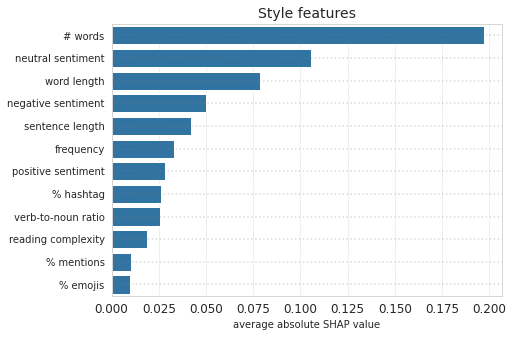

In [171]:
plt.subplots(figsize=(7,5))
for i in range(len(new_style_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
sns.barplot(data=sort_shaps[sort_shaps['feature_name'].isin(new_style_col)],
            x='value', y='feature_name', color=sns.color_palette()[0])
plt.xlabel('average absolute SHAP value')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Style features', fontsize=14)

Text(0.5, 1.0, 'Topics')

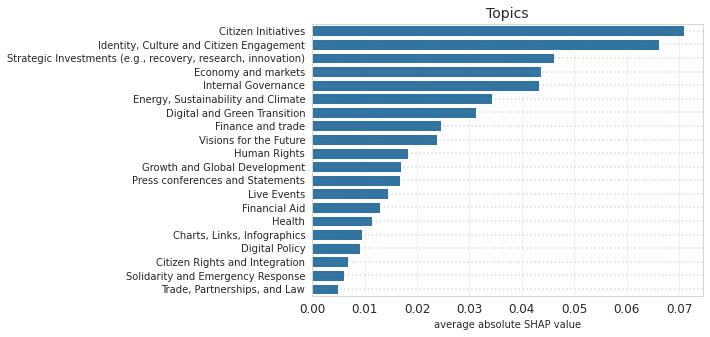

In [170]:
plt.subplots(figsize=(7,5))
for i in range(len(new_topic_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
sns.barplot(data=sort_shaps[sort_shaps['feature_name'].isin(new_topic_col)],
            x='value', y='feature_name', color=sns.color_palette()[0])
plt.xlabel('average absolute SHAP value')
plt.ylabel('')
plt.xticks(fontsize=12)
plt.title('Topics', fontsize=14)

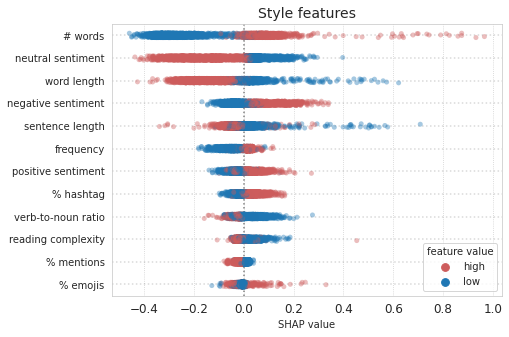

In [160]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plt.subplots(figsize=(7,5))
data = shaps_long[shaps_long['feature_name'].isin(new_style_col)]
data = data.merge(sort_shaps, on='feature_name').sort_values(by='value_y', ascending=False)
for i in range(len(new_style_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
plt.axvline(0, color='grey', linestyle='dotted')
sns.stripplot(data=data,
             y='feature_name', x='value_x', 
                hue='data_simple', palette=['indianred', 
                                            sns.color_palette()[0]],
                hue_order=['high', 'low'],
                alpha=.4)
plt.legend(title='feature value', loc='lower right')
plt.ylabel('')
plt.xlabel('SHAP value')
plt.xticks(fontsize=12)
plt.title('Style features', fontsize=14)
plt.show()

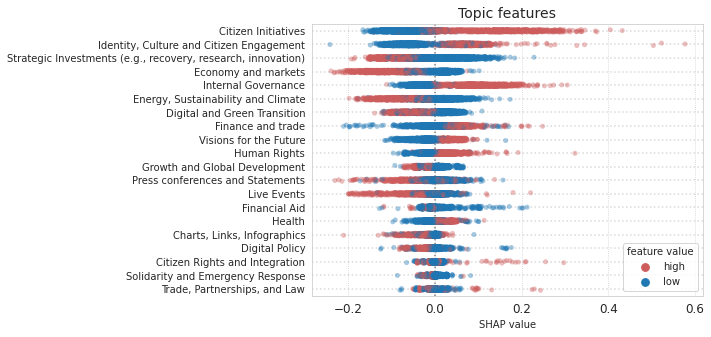

In [157]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plt.subplots(figsize=(7,5))
data = shaps_long[shaps_long['feature_name'].isin(new_topic_col)]
data = data.merge(sort_shaps, on='feature_name').sort_values(by='value_y', ascending=False)
for i in range(len(new_topic_col)):
    plt.axhline(i, linestyle='dotted', alpha=.3, color='grey')
plt.axvline(0, color='grey', linestyle='dotted')
sns.stripplot(data=data,
             y='feature_name', x='value_x', 
                hue='data_simple', palette=['indianred', 
                                            sns.color_palette()[0]],
                alpha=.4)
plt.legend(title='feature value', loc='lower right')
plt.ylabel('')
plt.xlabel('SHAP value')
plt.xticks(fontsize=12)
plt.title('Topic features', fontsize=14)
plt.show()